**1: Kütüphaneler ve Ayarlar**


In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import cv2
from skimage.feature import hog
import warnings

# Jupyter'da grafikleri satır içinde görmek için:
%matplotlib inline 
warnings.filterwarnings('ignore')

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


**2: Sabit Parametreler ve Klasör Yapısı**

In [6]:
# --- AYARLAR ---
IMG_SIZE = 128
BATCH_SIZE = 16    # her seferde işlecek görüntü sayısı
EPOCHS = 30
DATASET_PATH = 'dataset' 
RANDOM_STATE = 42   # sabit seed
MAX_IMAGES_PER_CLASS = 500 

os.makedirs('results', exist_ok=True)
print(f"Parametreler ayarlandı. Veri yolu: {DATASET_PATH}")

Parametreler ayarlandı. Veri yolu: dataset


**3: Veri Yükleme Fonksiyonu**

In [7]:
def load_images_and_labels(dataset_path, img_size=128):
    images = []
    labels = []
    class_names = []
    
    # Klasör kontrolü
    if not os.path.exists(dataset_path):
        print(f"HATA: '{dataset_path}' klasörü bulunamadı!")
        return np.array([]), np.array([]), []

    for class_name in sorted(os.listdir(dataset_path)):         #Healthy, LeafSpot, Fungal classları 
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path): continue
            
        class_names.append(class_name)
        print(f"Klasör işleniyor: {class_name}...", end="")
        
        all_imgs = os.listdir(class_path)
        selected_imgs = random.sample(all_imgs, min(len(all_imgs), MAX_IMAGES_PER_CLASS))
        
        count = 0
        for img_name in selected_imgs:
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_size, img_size))
                    images.append(img)
                    labels.append(class_name)
                    count += 1
            except: continue
        print(f" -> {count} görsel alındı.")
    
    return np.array(images), np.array(labels), class_names

**4: Veriyi Yükleme ve Bölme**

In [8]:
print("Veriler yükleniyor...")
images, labels, class_names = load_images_and_labels(DATASET_PATH , IMG_SIZE)

if len(images) > 0:
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Train/Test ayır
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_encoded
    )

    print(f"\nVeri Hazır!")
    print(f"Toplam Görüntü: {len(images)}")
    print(f"Eğitim Seti: {len(X_train)}")
    print(f"Test Seti: {len(X_test)}")
    print(f"Sınıflar: {class_names}")
else:
    print("\nUYARI: Hiç görüntü yüklenemedi. 'dataset' klasör yolunu kontrol et.")

Veriler yükleniyor...
Klasör işleniyor: fungal... -> 500 görsel alındı.
Klasör işleniyor: healthy... -> 500 görsel alındı.
Klasör işleniyor: leaf_spot... -> 500 görsel alındı.

Veri Hazır!
Toplam Görüntü: 1500
Eğitim Seti: 1200
Test Seti: 300
Sınıflar: ['fungal', 'healthy', 'leaf_spot']


In [9]:
print(X_train.shape)


(1200, 128, 128, 3)


**5: Model 1 - Random Forest (Özellik Çıkarımı ve Eğitim)**

In [10]:
def extract_features(image):
    """HOG + Renk özellikleri"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fd = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    
    # Renk histogramları
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [16], [0, 256])
        hist_features.extend(hist.flatten())
    
    color_mean = np.mean(image, axis=(0,1))
    color_std = np.std(image, axis=(0,1))
    return np.hstack([fd, hist_features, color_mean, color_std])

print("Random Forest için özellikler çıkarılıyor (biraz zaman alabilir)...")
X_train_rf = np.array([extract_features(img) for img in X_train])
X_test_rf = np.array([extract_features(img) for img in X_test])

print("Random Forest eğitiliyor...")
rf_model = RandomForestClassifier(n_estimators=150, max_depth=20, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_rf, y_train)

rf_test_pred = rf_model.predict(X_test_rf)
rf_acc = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest Başarısı (Accuracy): {rf_acc:.2%}")

Random Forest için özellikler çıkarılıyor (biraz zaman alabilir)...
Random Forest eğitiliyor...
Random Forest Başarısı (Accuracy): 86.33%


**6: Derin Öğrenme Hazırlığı (Normalizasyon ve Augmentation)**

In [ ]:
# Verileri Normalize Et (0-255 -> 0-1)
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Etiketleri One-Hot Formatına Çevir
num_classes = len(class_names)
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Veri Çoğaltma (Augmentation) Ayarları
datagen = ImageDataGenerator(
    rotation_range=15,    #±15 derece döndürme
    width_shift_range=0.1,   #Yatay kaydırma
    height_shift_range=0.1,  #Dikey kaydırma
    horizontal_flip=True,  #Aynalama
    zoom_range=0.1   #Yakınlaştırma
)

# Callback'ler
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)

print("Derin öğrenme verileri hazırlandı.")

Derin öğrenme verileri hazırlandı.


**7: Model 2 - CNN Modeli ve Eğitimi**

In [12]:
def create_cnn():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("--- CNN Eğitimi Başlıyor ---")
cnn_model = create_cnn()
cnn_hist = cnn_model.fit(
    datagen.flow(X_train_norm, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_test_norm, y_test_cat),
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

--- CNN Eğitimi Başlıyor ---
Epoch 1/30
75/75 - 29s - 384ms/step - accuracy: 0.6183 - loss: 1.2482 - val_accuracy: 0.3333 - val_loss: 2.0613 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 - 25s - 332ms/step - accuracy: 0.7333 - loss: 0.6427 - val_accuracy: 0.3333 - val_loss: 4.0990 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 - 25s - 327ms/step - accuracy: 0.7733 - loss: 0.5636 - val_accuracy: 0.3533 - val_loss: 3.7975 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 - 25s - 327ms/step - accuracy: 0.7917 - loss: 0.5092 - val_accuracy: 0.4767 - val_loss: 4.2529 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 - 25s - 331ms/step - accuracy: 0.8133 - loss: 0.4513 - val_accuracy: 0.4900 - val_loss: 3.3558 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 - 24s - 321ms/step - accuracy: 0.8417 - loss: 0.4169 - val_accuracy: 0.6267 - val_loss: 1.6385 - learning_rate: 5.0000e-05
Epoch 7/30
75/75 - 26s - 342ms/step - accuracy: 0.8567 - loss: 0.3761 - val_accuracy: 0.7967 - val_loss: 0.7393 - learning_rate: 5.

**8: Model 3 - Transfer Learning (MobileNetV2) ve Eğitimi**

In [13]:
def create_tl():
    base = MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
    
    # Fine-tuning: Son 20 katmanı eğitilebilir yap
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False
    
    model = keras.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("--- MobileNetV2 Eğitimi Başlıyor ---")
tl_model = create_tl()
tl_hist = tl_model.fit(
    datagen.flow(X_train_norm, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_test_norm, y_test_cat),
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

--- MobileNetV2 Eğitimi Başlıyor ---
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 257ms/step - accuracy: 0.7617 - loss: 0.5716 - val_accuracy: 0.8033 - val_loss: 0.5510 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.9208 - loss: 0.2201 - val_accuracy: 0.8367 - val_loss: 0.4694 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.9342 - loss: 0.1829 - val_accuracy: 0.8867 - val_loss: 0.3211 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.9617 - loss: 0.1478 - val_accuracy: 0.8633 - val_loss: 0.4321 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step - accuracy: 0.9675 - loss: 0.0873 - val_accuracy: 0.8900 - val_loss: 0.3754 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.9767 - loss: 0.0797 - val_accuracy: 0.9233 - val_loss: 0.2319 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━

**9: Sonuçların Hesaplanması**

In [14]:
print("Tahminler yapılıyor...")
cnn_pred_probs = cnn_model.predict(X_test_norm, verbose=0)
cnn_pred = np.argmax(cnn_pred_probs, axis=1)

tl_pred_probs = tl_model.predict(X_test_norm, verbose=0)
tl_pred = np.argmax(tl_pred_probs, axis=1)

cnn_acc = accuracy_score(y_test, cnn_pred)
tl_acc = accuracy_score(y_test, tl_pred)

# Sonuç Tablosu
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Simple CNN', 'MobileNetV2'],
    'Test Accuracy': [rf_acc, cnn_acc, tl_acc],
    'Fark (vs RF)': ['-', f'+{(cnn_acc-rf_acc)*100:.1f}%', f'+{(tl_acc-rf_acc)*100:.1f}%']
})

print("\n--- SONUÇLAR ---")
print(results_df)

best_model_name = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Model']
print(f"\n🏆 En başarılı model: {best_model_name}")

Tahminler yapılıyor...

--- SONUÇLAR ---
           Model  Test Accuracy Fark (vs RF)
0  Random Forest       0.863333            -
1     Simple CNN       0.906667        +4.3%
2    MobileNetV2       0.976667       +11.3%

🏆 En başarılı model: MobileNetV2


**10: Görselleştirme 1 - Karşılaştırma Grafiği**

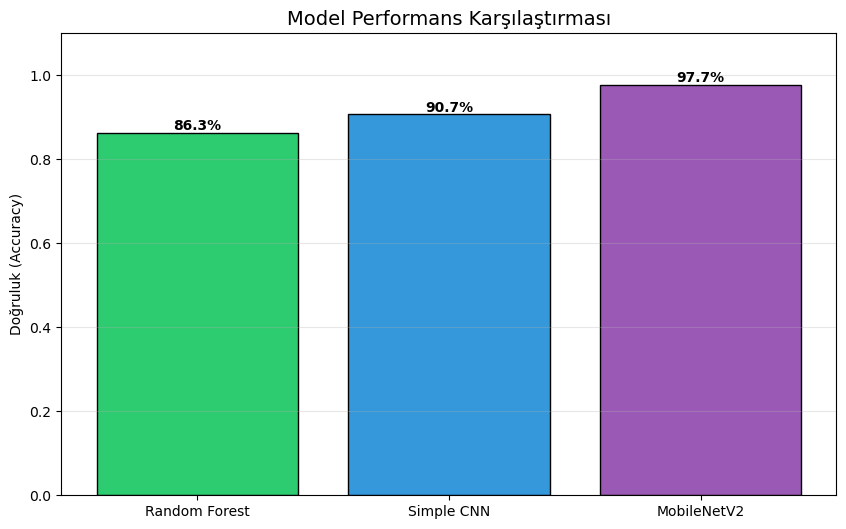

In [15]:
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = plt.bar(results_df['Model'], results_df['Test Accuracy'], color=colors, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1%}', 
             ha='center', va='bottom', fontweight='bold')

plt.title('Model Performans Karşılaştırması', fontsize=14)
plt.ylabel('Doğruluk (Accuracy)')
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.savefig('results/model_comparison.png') 
plt.show()

**11: Görselleştirme 2 - Confusion Matrix**

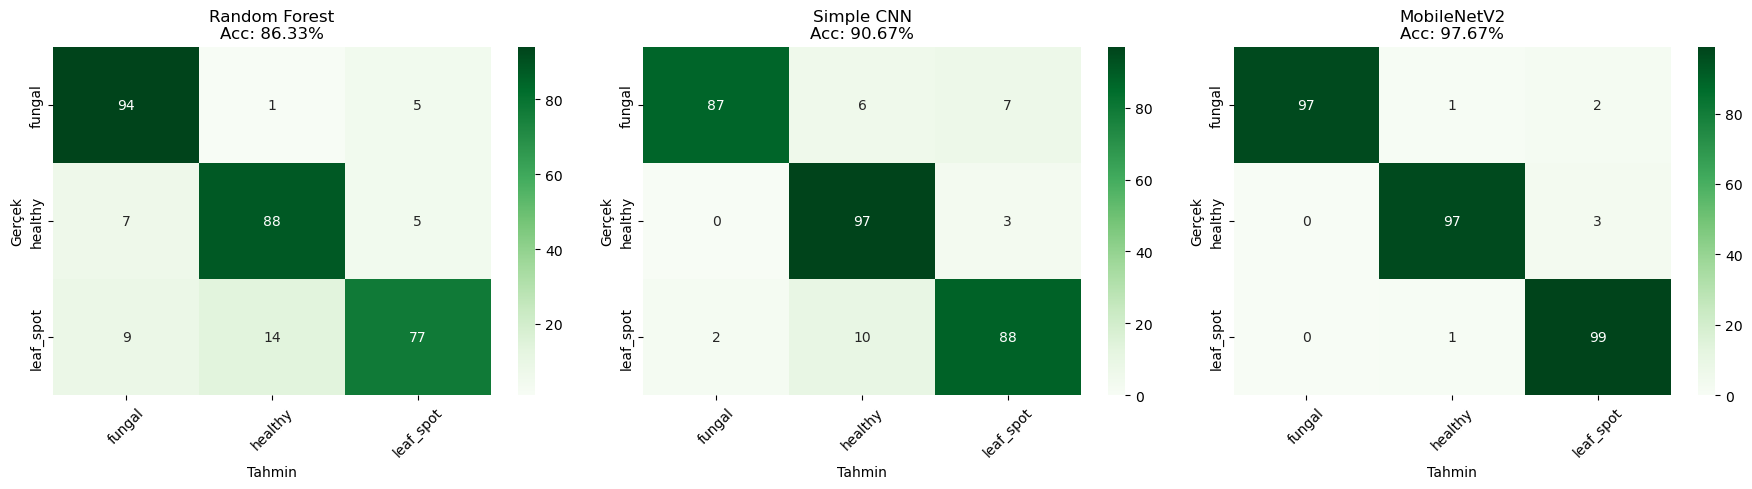

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_list = [
    ('Random Forest', rf_test_pred),
    ('Simple CNN', cnn_pred),
    ('MobileNetV2', tl_pred)
]

for i, (name, pred) in enumerate(models_list):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f"{name}\nAcc: {accuracy_score(y_test, pred):.2%}")
    axes[i].set_xlabel('Tahmin')
    axes[i].set_ylabel('Gerçek')
    # X eksenindeki yazıları döndür (okunabilirlik için)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('results/confusion_matrices.png')
plt.show()

**12: Görselleştirme 3 - Eğitim Geçmişi (Loss & Accuracy)**

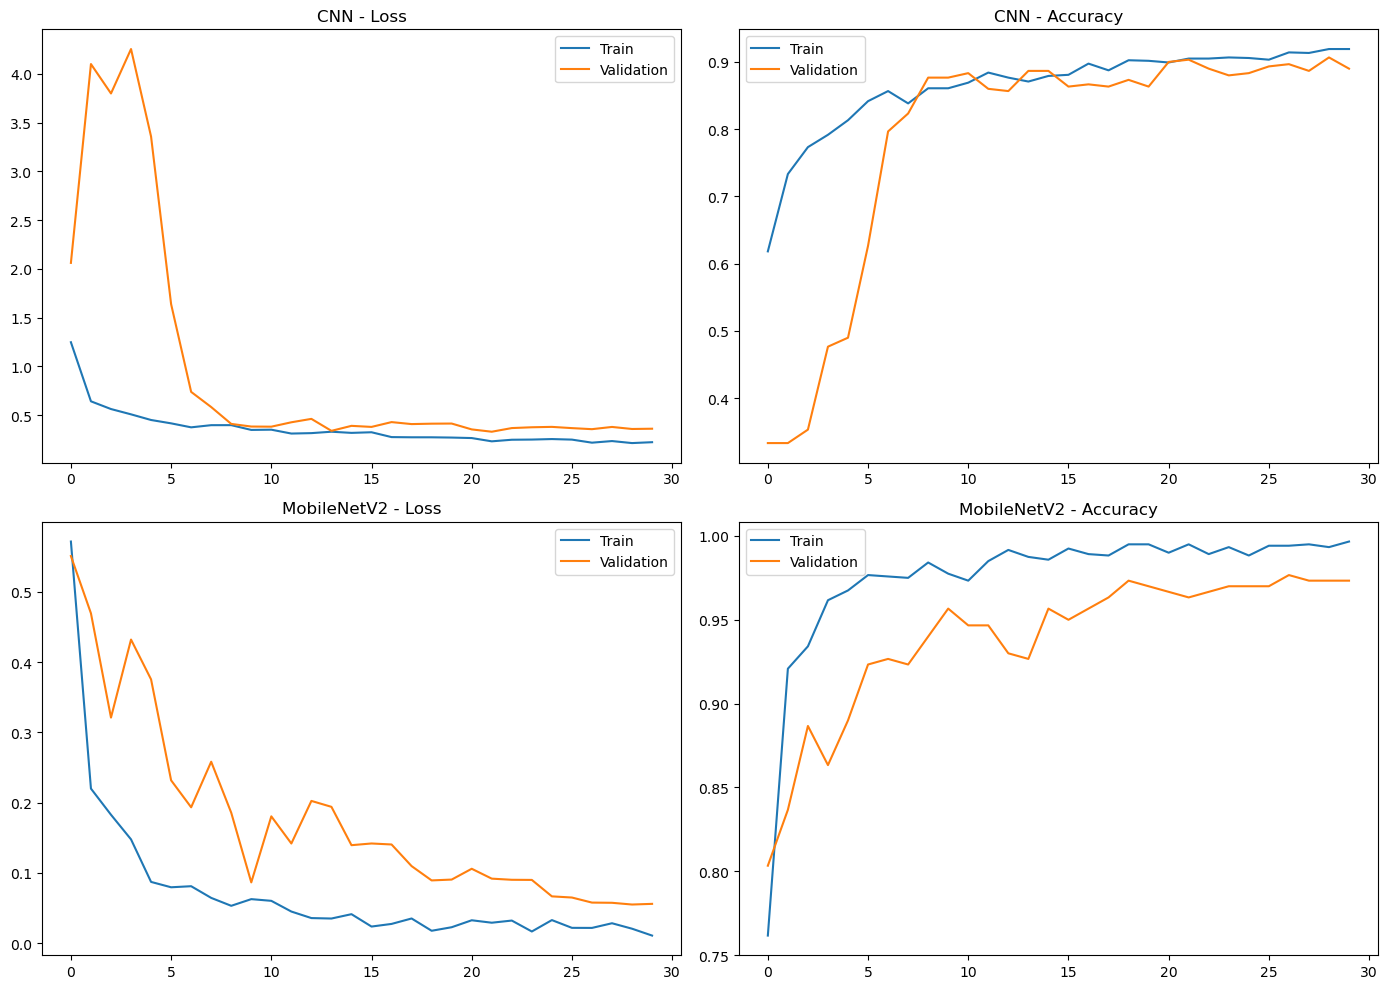

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CNN Grafikleri
axes[0,0].plot(cnn_hist.history['loss'], label='Train')
axes[0,0].plot(cnn_hist.history['val_loss'], label='Validation')
axes[0,0].set_title('CNN - Loss')
axes[0,0].legend()

axes[0,1].plot(cnn_hist.history['accuracy'], label='Train')
axes[0,1].plot(cnn_hist.history['val_accuracy'], label='Validation')
axes[0,1].set_title('CNN - Accuracy')
axes[0,1].legend()

# MobileNet Grafikleri
axes[1,0].plot(tl_hist.history['loss'], label='Train')
axes[1,0].plot(tl_hist.history['val_loss'], label='Validation')
axes[1,0].set_title('MobileNetV2 - Loss')
axes[1,0].legend()

axes[1,1].plot(tl_hist.history['accuracy'], label='Train')
axes[1,1].plot(tl_hist.history['val_accuracy'], label='Validation')
axes[1,1].set_title('MobileNetV2 - Accuracy')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('results/training_history.png')
plt.show()

**13: Raporlama ve Kaydetme**

In [18]:
from sklearn.metrics import classification_report

# 1. Önce Modelleri Kaydet
cnn_model.save('results/cnn_model.h5')
tl_model.save('results/mobilenet_model.h5')
print("Modeller başarıyla kaydedildi.")

# 2. Rapor Metinlerini Hazırla
# Not: Bu değişkenlerin (rf_test_pred vb.) hafızada olması için önceki hücrelerin çalışmış olması gerekir.
report_rf = classification_report(y_test, rf_test_pred, target_names=class_names)
report_cnn = classification_report(y_test, cnn_pred, target_names=class_names)
report_tl = classification_report(y_test, tl_pred, target_names=class_names)

# 3. EKRANA YAZDIR 
print("\n" + "="*70)
print("BİTKİ YAPRAĞI HASTALIĞI SINIFLANDIRMA PROJESİ - SONUÇ RAPORU")
print("="*70)

print("\n" + "="*70)
print("GENEL MODEL PERFORMANSLARI")
print("="*70)
print(results_df.to_string(index=False))

print("\n" + "="*70)
print("1. RANDOM FOREST - DETAYLI SINIFLANDIRMA RAPORU")
print("="*70)
print(report_rf)

print("\n" + "="*70)
print("2. SIMPLE CNN - DETAYLI SINIFLANDIRMA RAPORU")
print("="*70)
print(report_cnn)

print("\n" + "="*70)
print(" 3. MOBILENETV2 - DETAYLI SINIFLANDIRMA RAPORU")
print("="*70)
print(report_tl)

print("\n" + "="*70)
print("DEĞERLENDİRME VE YORUMLAR")
print("="*70)
best_model_name = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Model']
best_acc = results_df['Test Accuracy'].max()

print(f"1. EN BAŞARILI MODEL: {best_model_name} (%{best_acc*100:.2f})")
print(f"2. KLASIK ML vs DERİN ÖĞRENME:")
print(f"   - Random Forest: %{rf_acc*100:.2f}")
print(f"   - En İyi CNN Modeli Farkı: +%{(best_acc-rf_acc)*100:.2f}")
print("   -> Derin öğrenme, özellik çıkarımında klasik yöntemlere göre üstünlük sağladı.")


# 4. Dosyaya Kaydetme
with open('results/detailed_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("BİTKİ YAPRAĞI HASTALIĞI SINIFLANDIRMA PROJESİ - SONUÇ RAPORU\n")
    f.write("="*70 + "\n\n")
    
    f.write("GENEL TABLO:\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("="*70 + "\n")
    f.write("1. RANDOM FOREST RAPORU\n")
    f.write("="*70 + "\n")
    f.write(report_rf)
    f.write("\n\n")

    f.write("="*70 + "\n")
    f.write("2. SIMPLE CNN RAPORU\n")
    f.write("="*70 + "\n")
    f.write(report_cnn)
    f.write("\n\n")

    f.write("="*70 + "\n")
    f.write("3. MOBILENETV2 RAPORU\n")
    f.write("="*70 + "\n")
    f.write(report_tl)

print("\n📄 Rapor dosyaya da yazıldı: results/detailed_report.txt")

Modeller başarıyla kaydedildi.

BİTKİ YAPRAĞI HASTALIĞI SINIFLANDIRMA PROJESİ - SONUÇ RAPORU

GENEL MODEL PERFORMANSLARI
        Model  Test Accuracy Fark (vs RF)
Random Forest       0.863333            -
   Simple CNN       0.906667        +4.3%
  MobileNetV2       0.976667       +11.3%

1. RANDOM FOREST - DETAYLI SINIFLANDIRMA RAPORU
              precision    recall  f1-score   support

      fungal       0.85      0.94      0.90       100
     healthy       0.85      0.88      0.87       100
   leaf_spot       0.89      0.77      0.82       100

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300


2. SIMPLE CNN - DETAYLI SINIFLANDIRMA RAPORU
              precision    recall  f1-score   support

      fungal       0.98      0.87      0.92       100
     healthy       0.86      0.97      0.91       100
   leaf_spot       0.90      0.88      0.89       100

    accuracy     